# DSCI 575 - Advanced Machine Learning

# Lab 3: Topic modeling with LDA 

## Table of contents
- [Submission instructions](#si) (4%)
- [Imports](#im)
- [Exercise 1: Data and preprocessing](#1) (26%)
- [Exercise 2: Building a baseline topic model](#2) (16%)
- [Exercise 3: Hyperparameter optimization](#3) (14%)
- [Exercise 4: Visualizing topic models](#4) (20%)
- [Exercise 5: Interpreting topic models](#5) (20%)


<br><br>

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:4}

You will receive marks for correctly submitting this assignment. 
 
To correctly submit this assignment follow the instructions below:

- Push your assignment to your GitHub repository. 
- Add a link to your GitHub repository here: https://github.ubc.ca/MDS-2020-21/DSCI_575_lab3_lhabashy
- Upload an HTML render of your assignment to Canvas. The last cell of this notebook will help you do that.
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).

[Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.

**NOTE: The data you download for use in this lab SHOULD NOT BE PUSHED TO YOUR REPOSITORY. You might be penalized for pushing datasets to your repository.**

<br><br>

## Imports <a name="im"></a>

In [1]:
import re
import string

import gensim
import gensim.corpora as corpora
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora import Dictionary
from gensim.models import LdaModel

pyLDAvis.enable_notebook()
pd.set_option("display.max_colwidth", 100)

In [2]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/larahabashy/Downloads/miniconda3/envs/575/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<br><br><br><br>

## Exercise 1: Data and preprocessing <a name="1"></a>
<hr>

In this lab you will explore topics in `scikit-learn`'s [20 newsgroups text dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) using [`gensim`'s `ldamodel`](https://radimrehurek.com/gensim/models/ldamodel.html). Usually, topic modeling is used for discovering abstract "topics" that occur in a collection of documents when you do not know the actual topics present in the documents. But 20 newsgroups text dataset is labeled with categories (e.g., sports, hardware, religion), and you will be able to cross-check the topics discovered by your model with these available topics. 

The starter code below loads the train and test portion of the data and convert the train portion into a pandas DataFrame.

<br><br>

In [3]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

In [4]:
newsgroups_train = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes")
)
newsgroups_test = fetch_20newsgroups(
    subset="test", remove=("headers", "footers", "quotes")
)
X_news_train, y_news_train = newsgroups_train.data, newsgroups_train.target
X_news_test, y_news_test = newsgroups_test.data, newsgroups_test.target
df = pd.DataFrame(X_news_train, columns=["text"])

In [5]:
df["target"] = y_news_train
df["target_name"] = [
    newsgroups_train.target_names[target] for target in newsgroups_train.target
]
df

,text,target,target_name
0,I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was ...,7,rec.autos
1,A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experienc...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k wa...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? I'd like to get some information\nabout this chip.\n,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n\n\nMy unders...",14,sci.space
...,...,...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nDN> A neurology\nDN> consultation is cheaper than a...,13,sci.med
11310,"I have a (very old) Mac 512k and a Mac Plus, both of which \nhave the same problem.\n\nTheir scr...",4,comp.sys.mac.hardware
11311,"I just installed a DX2-66 CPU in a clone motherboard, and tried mounting a CPU \ncooler on the c...",3,comp.sys.ibm.pc.hardware
11312,"\nWouldn't this require a hyper-sphere. In 3-space, 4 points over specifies\na sphere as far as...",1,comp.graphics


Here are the 20 topics from the dataset. 

In [6]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

<br><br>

### 1.1 Preprocessing
rubric={accuracy:10,reasoning:4}

In this exercise you'll prepare the data for topic modeling using [spaCy](https://spacy.io/). Preprocessing is a crucial step before training an LDA model and it markedly affects topic modeling results. So let's carry out preprocessing. 

**Your tasks:** 

1. Complete the function `preprocess` below to carry out preprocessing of a given text. Note that there is no such thing as "perfect" preprocessing. You'll have to make your own judgments and decisions on which tokens are more informative and which ones are less informative for the given task. Some common text preprocessing steps for topic modeling are: 
    - getting rid of slashes, new-line characters etc.
    - sentence segmentation and tokenization      
    - getting rid of email addresses
    - getting rid of other fairly unique tokens which are not going to help us in topic modeling  
    - excluding stopwords and punctuation 
    - lemmatization 
2. Carry out preprocessing of the `text` column from the dataframe `df` above and create a new column called `text_pp` in the dataframe. 
        
> Feel free to change the function signature if you need to. 

> Check out [these available attributes](https://spacy.io/api/token#attributes) for `token` in spaCy. 

> [Here](https://spacy.io/api/annotation/#pos-en) is the list of part-of-speech tags used in spaCy. 

> Note that preprocessing the corpus might take some time. So here are a couple of suggestions: 1) During the debugging phase, work on a smaller subset of the data. 2) Once you're done with the preprocessing part, you might want to save the preprocessed data so that you don't run the preprocessing part every time you run the notebook. 


In [7]:
def preprocess(
    text,
    min_token_len=2,
    irrelevant_pos=["ADV", "PRON", "CCONJ", "PUNCT", "PART", "DET", "ADP", "SPACE"],
):
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text
    and return a preprocessed string.

    Parameters
    -------------
    text : (str)
        text to be preprocessed
    min_token_len : (int)
        minimum token length required to keep a token in the preprocessed text
    irrelevant_pos : (list)
        a list of irrelevant pos tags

    Returns
    -------------
    (str) the preprocessed text
    """
    ### Solution_1_1_1
    ### YOUR ANSWER HERE
    
    # Code adapted from Lecture 5 - by Varada 
    
    clean_text = []

    for token in text:
        if (
            token.is_stop == False  # Check if it's not a stopword
            and len(token) > min_token_len  # Check if the word meets minimum threshold
            and token.pos_ not in irrelevant_pos
            and token.like_email == False
            and token.is_punct == False
            and token.text not in list(string.punctuation)
            and token.is_alpha == True
        ):  # Check if the POS is in the acceptable POS tags
            lemma = token.lemma_  # Take the lemma of the word
            clean_text.append(lemma.lower())
    return " ".join(clean_text)
    

In [9]:
### Solution_1_1_2
### YOUR ANSWER HERE

import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

df["text_pp"] = [preprocess(text) for text in nlp.pipe(df["text"])]

In [10]:
df['text'].iloc[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [11]:
df['text_pp'].iloc[0]

'wonder enlighten car see day door sport car look late early call bricklin door small addition bumper separate rest body know tellme model engine spec year production car history info funky look car mail'

<br><br>

### 1.2 Build a dictionary and a document-term co-occurrence matrix
rubric={accuracy:8,reasoning:4}

In order to build `gensim`'s `LdaModel`, we need two things: a dictionary and a document-term co-occurrence matrix. 

**Yout tasks:**
1. Create a dictionary using `gensim`'s [`corpora.Dictionary`](https://radimrehurek.com/gensim/corpora/dictionary.html) method. 
2. Create a document-term co-occurrence matrix using `corpora.Dictionary`'s `doc2bow` method. 
3. What's the size of the dictionary? Examine the first row of document-term co-occurrence matrix and briefly explain what does each entry contain in this matrix.   

> You may want to explore [`filter_extremes`](https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html) method of dictionary to speed things up. You can use reasonable hyperparameter values of your choice. 

In [12]:
### Solution_1_2_1 and Solution_1_2_2

### YOUR ANSWER HERE"

corpus = [text.split() for text in df["text_pp"].tolist()]
dictionary = corpora.Dictionary(corpus)  # Create a vocabulary for the lda model
pd.DataFrame(
    dictionary.token2id.keys(), index=dictionary.token2id.values(), columns=["Word"]
)

,Word
0,addition
1,body
2,bricklin
3,bumper
4,call
...,...
48037,millie
48038,paroxysmal
48039,bodin
48040,equi


In [13]:
doc_term_matrix = [dictionary.doc2bow(text) for text in corpus]

In [14]:
corpus[0]

['wonder',
 'enlighten',
 'car',
 'see',
 'day',
 'door',
 'sport',
 'car',
 'look',
 'late',
 'early',
 'call',
 'bricklin',
 'door',
 'small',
 'addition',
 'bumper',
 'separate',
 'rest',
 'body',
 'know',
 'tellme',
 'model',
 'engine',
 'spec',
 'year',
 'production',
 'car',
 'history',
 'info',
 'funky',
 'look',
 'car',
 'mail']

In [15]:
### Solution_1_2_3

### YOUR ANSWER HERE"
print(f"The size of the dictionary is {(len(dictionary.token2id.keys()))}.")
doc_term_matrix[0][:20]                                

The size of the dictionary is 48042.


[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 4),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 1),
 (19, 1)]

### YOUR ANSWER HERE

> Examining the first row of the document term matrix, we see that each item is a tuple where the first entry corresponds to a unique word in the corpus and the second entry corresponds to the word frequency i.e. how many time it appears in any given document.

<br><br><br><br>

## Exercise 2: Building a baseline topic model <a name="2"></a>
<hr>

### 2.1 Build a baseline topic model
rubric={accuracy:12,reasoning:4}

In this exercise you will build a baseline LDA topic model on the prepared data. 

**Your tasks:**

1. Build an LDA model using `gensim`'s [`models.LdaModel`](https://radimrehurek.com/gensim/models/ldamodel.html) with `num_topics` = 8 and `random_state=100`.
2. Examine the topics. Also, examine topic assignments for a few documents. Do the topics make sense? Are they too fine-grained or too coarse-grained? 

> Note: If you get many warnings when you build your model, update your `gensim` installation.  See [here](https://github.com/RaRe-Technologies/gensim/pull/2296).

In [16]:
lda8 = None

### Solution_2_1_1
### YOUR ANSWER HERE

from gensim.models import LdaModel

num_topics = 8

lda8 = LdaModel(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100,
    passes=10,
)

In [17]:
### Solution_2_1_2

### YOUR ANSWER HERE


In [18]:
### YOUR ANSWER HERE

sample_ids = df.sample(20, random_state=123).index.tolist()

In [19]:
topics_lda = [sorted(lda8[doc_term_matrix[sample]], key=lambda x:x[1], reverse=True)[0] for sample in sample_ids]

In [20]:
props = [x[1] for x in topics_lda]
topics = [x[0] for x in topics_lda]

In [21]:
sample_df = df.iloc[sample_ids]
sample_df['topics by LDA']= topics
sample_df['probability']= props
sample_df

<ipython-input-21-dbf7895b7d36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['topics by LDA']= topics
<ipython-input-21-dbf7895b7d36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['probability']= props


,text,target,target_name,text_pp,topics by LDA,probability
872,"\n\nBut, you wouldn't know what red *was*, and you certainly couldn't judge\nit subjectively. A...",0,alt.atheism,know red judge objectivity applicable want discuss merit red,4,0.912340
10976,\nSorry. Wrong. This is how banks got started in the first place.\nSooner or later your fat...,0,alt.atheism,sorry wrong bank get start place father pal lend money go broke realise manage risk ask need qua...,0,0.362845
2573,"\nWhile that is currently true from their perspective, it is also\nworthwhile to note that in su...",17,talk.politics.mideast,true perspective worthwhile note case populace suffer attempt control guerilla case past palesti...,6,0.415739
11214,\n\nNonsense. I quite clearly state that it was Greg that made the claim\nthat Gainey never mad...,10,rec.sport.hockey,nonsense state greg claim gainey error claim read thu apr uvic greg ballentine message uvic nons...,4,0.434352
10939,"\n\nA list of options that would be useful. They can be existing\noptions on a car, or things yo...",7,rec.autos,list option useful exist option car thing like tripmeter great little gadget let rough track mil...,7,0.678758
6240,"\nPlease, define cell church. I missed it somewhere in the past when this\nwas brought up before.",15,soc.religion.christian,define cell church miss past bring,4,0.595626
11190,There are actually a few important things we can glean from this mess:\n1)\tWhen they start gett...,19,talk.religion.misc,important thing glean mess start get desperate answer question natural pinkboy buy darn near mea...,0,0.738320
4551,At one time there was speculation that the first spacewalk \n(Alexei Leonov ?) was a staged fake...,14,sci.space,time speculation spacewalk alexei leonov stage fake evidence support contradict claim emerge cla...,0,0.594841
4863,"\nIMO, a Christian has no need of weapons. I know it is very contrary to the\nAmerican NRA etho...",19,talk.religion.misc,christian need weapon know contrary american nra ethos right bear arm christians rely strength g...,4,0.728540
664,"One ""t"" in ""Eddie Mathews""!\nBecause a small advantage in fielding ability comes nowhere near\nm...",9,rec.sport.baseball,eddie mathews small advantage field ability come near make large difference hit average season c...,7,0.690983


In [22]:
topic_assign_matrix = [sorted(lda8[doc_term_matrix[sample]], key= lambda x:x[1], reverse=True)for sample in sample_ids]

In [23]:
topic_assign_matrix[1]

[(0, 0.3628428), (3, 0.30093008), (7, 0.19665796), (4, 0.12934911)]

### YOUR ANSWER HERE

> The topics make sense for the most part but they seem to be a little too fine-grained. For instance, we can see that our LDA model assigned documents {11049, 7548, 6323} topics 7, 4, and 5, respectively, when the initial labelling had all of those 3 documents under a single topic, topic 8.

<br><br><br><br>

## Exercise 3: Hyperparameter optimization <a name="3"></a>
<hr>

### 3.1 Optimizing number of topics using coherence score
rubric={accuracy:10,reasoning:4}

**Your tasks**

1. Experiment with a few choices of the `num_topics` hyperparameter, examining coherence score for each of them using [coherence model](https://radimrehurek.com/gensim/models/coherencemodel.html).  
2. Settle on the number of topics where the coherence score is reasonable and the topics make sense to you. 
3. Briefly comment on the coherence scores and the final number of topics you settled on. 

In [24]:
### Solution_3_1_1

### YOUR ANSWER HERE

# Code adapted from lecture 5

# Compute Coherence Score
from gensim.models import CoherenceModel

K = range(8, 23, 2)

coherence_scores = []

for num_topics in K:
    lda = LdaModel(
        corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        passes=10,
    )
    coherence_model_lda = CoherenceModel(
        model=lda, texts=corpus, dictionary=dictionary, coherence="c_v"
    )
    coherence_scores.append(coherence_model_lda.get_coherence())


In [25]:
### YOUR ANSWER HERE
coh_df = pd.DataFrame(coherence_scores, index=K, columns=["Coherence score"])
coh_df

,Coherence score
8,0.498135
10,0.594690
12,0.537470
14,0.529439
16,0.563647
18,0.596932
20,0.588660
22,0.579076


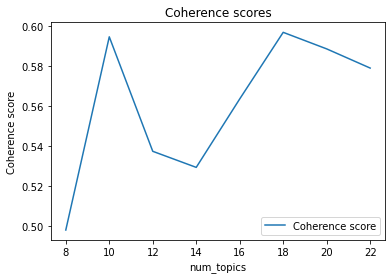

In [26]:
### Solution_3_1_2

### YOUR ANSWER HERE
coh_df.plot(title="Coherence scores", xlabel="num_topics", ylabel="Coherence score");

**Solution_3_1_3**

### YOUR ANSWER HERE

> Based on the computed coherence scores above, and the plot above, it appears the best candidates for `num_topics` are 10 and 18, with the highest coherence scores. That is, they have the highest semantic simarily between the most common in those topics. To avoid my topic assignments being too fine, I am going to pick `num_topics=10`. 

<br><br>

### (Optional) 3.2 Optimizing `alpha` and `eta`
rubric={reasoning:1}

**Your tasks:**

Experiment with the following hyperparameters of the LDA model: 
- Dirichlet hyperparameter `alpha`: document-topic density
- Dirichlet hyperparameter `eta`: word-topic density

> We haven't talked much about these hyperparameters in class. You'll have to go through [the documentation](https://radimrehurek.com/gensim/models/ldamodel.html) to understand the meaning of these hyperparameters. 

<br><br><br><br>

## Exercise 4: Visualizing topic models <a name="4"></a>
<hr>

### 4.1 Visualization
rubric={viz:8,reasoning:4}

Once we settle on the number of topics, we can train an LDA model using the best number of topics, and visualize and interpret the topics. 

**Your tasks:**

1. Train an LDA model with the best number of topics you picked in 3.1. 
2. Visualize the topics using [pyLDAvis](https://github.com/bmabey/pyLDAvis), which is a Python library for interactive topic model visualization. 
3. Briefly comment on the topics. Which topics are close to each other? Do we have any overlapping topics? 

> When training an LDA model, set the `random_state` parameter so that the topic are reproducible. 

> In visualization, use `sort_topics=False`. Otherwise the topic ids in visualization won't match with the topic ids given by the trained LDA model.  

> Your LDA visuzliation might not show up in the browser and you might have to take a screenshot and put it in your submission. 

In [27]:
optimal_k = 10

lda = LdaModel(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=optimal_k,
    random_state=100,
    passes=10,
)

In [28]:
# Visualize the topics
#vis = gensimvis.prepare(lda, doc_term_matrix, dictionary, sort_topics=False)
#vis

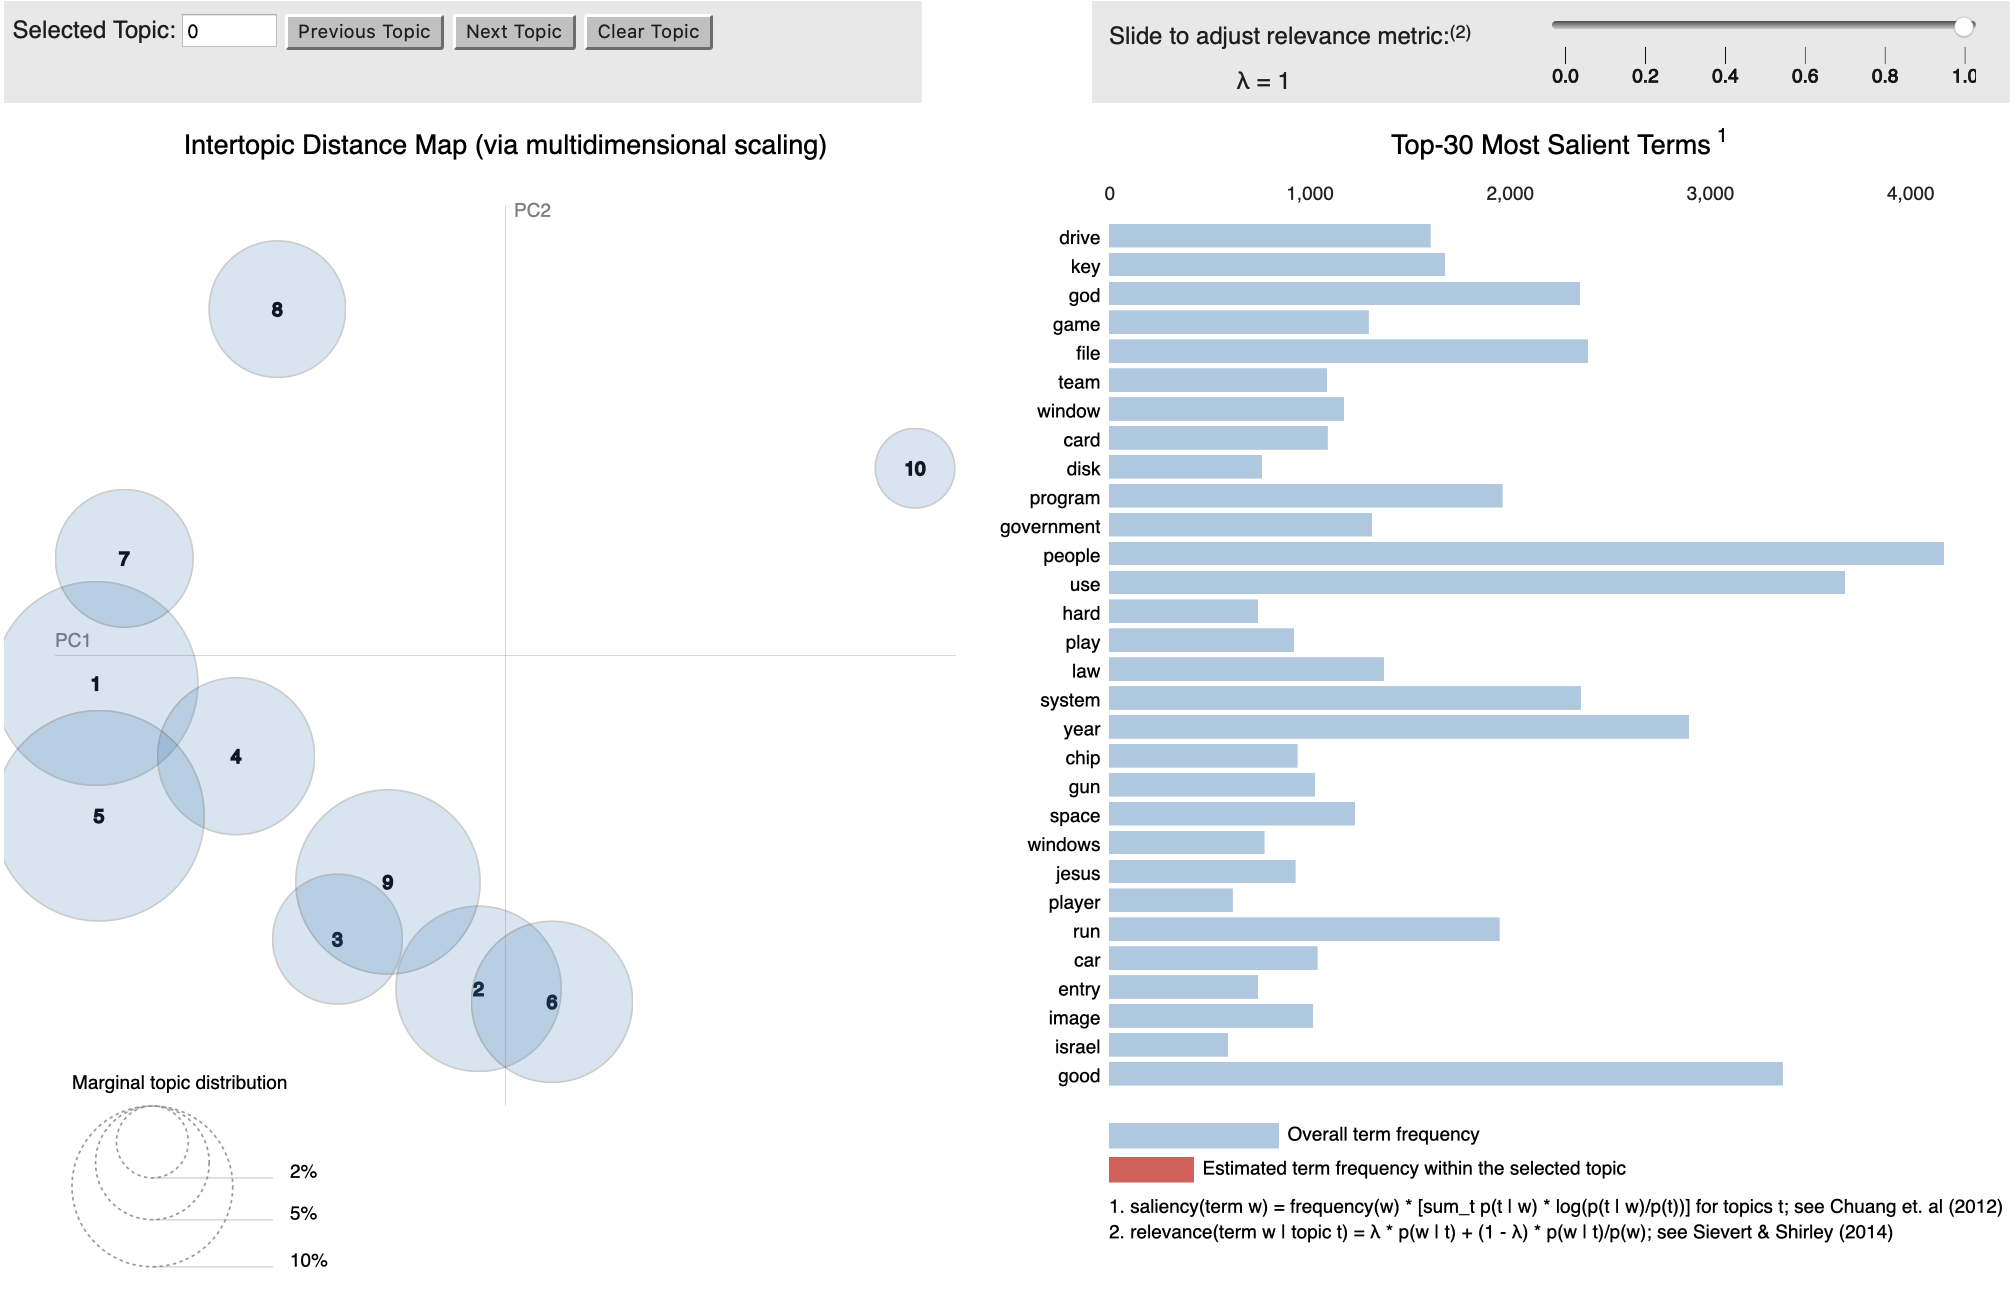

In [29]:
from IPython.display import Image
Image(filename='ldaviz.png')

**Solution_4_1_3**
### YOUR ANSWER HERE

> Looking at the above visualization, we can see than topics 8 and 10 are quite distinct, with smaller marginal distributions that are further away from the other 8 topics. Topic 7 also appears to be a distinct topic. We also see that most of the other topics are close in distance and overlapping, some almost half overlapping such as topics 2 and 6. Further investigating these two topics, we see that the distinction is there, but they naturally share many frequent words. Perhaps a smaller number of topics would be more appropriate here, and would minimize overlapping topics.

<br><br>

### 4.2 Manually labeling topics 
rubric={accuracy:4,reasoning:4}

**Your tasks:**
1. Examine a few top words for each topic manually and try to assign a "name" or a "label" to each topic (e.g., *sports, politics, religion*) based on the common theme in the most probable words in that topic. In particular, create a dictionary named `topic_labels` with topic ids as keys and your manually-assigned topic label as values (e.g., something like: 0: "Science and technology").

> You may use the `target_name` values (e.g., sci.crypt, rec.sport.hockey) as topic labels if you like. 

In [30]:
topic_labels = {}

### Solution_4_2_1
### YOUR ANSWER HERE

topic_labels = {0: 'talk.politics.guns', 1: 'comp.hardware', 2: 'sci.crypt', 3: 'talk.politics.us',
               4: 'religion', 5: 'comp.program', 6: 'talk.politics.mideast', 7: 'rec.sports',
               8: 'rec.auto', 9: 'gaming'}
topic_labels

{0: 'talk.politics.guns',
 1: 'comp.hardware',
 2: 'sci.crypt',
 3: 'talk.politics.us',
 4: 'religion',
 5: 'comp.program',
 6: 'talk.politics.mideast',
 7: 'rec.sports',
 8: 'rec.auto',
 9: 'gaming'}

In [31]:
### Examine the topics in our LDA model
lda.print_topics(num_words=4)
#lda.print_topics(num_words=20)

[(0, '0.012*"know" + 0.011*"people" + 0.011*"go" + 0.011*"think"'),
 (1, '0.013*"file" + 0.008*"space" + 0.008*"include" + 0.008*"entry"'),
 (2, '0.028*"key" + 0.011*"chip" + 0.010*"law" + 0.010*"use"'),
 (3,
  '0.008*"president" + 0.007*"year" + 0.005*"program" + 0.005*"stephanopoulos"'),
 (4, '0.016*"god" + 0.010*"people" + 0.009*"think" + 0.008*"believe"'),
 (5, '0.013*"window" + 0.012*"file" + 0.012*"use" + 0.010*"run"'),
 (6, '0.009*"israel" + 0.009*"war" + 0.008*"armenian" + 0.008*"people"'),
 (7, '0.021*"game" + 0.017*"team" + 0.013*"play" + 0.012*"year"'),
 (8, '0.009*"good" + 0.008*"use" + 0.008*"know" + 0.008*"new"'),
 (9, '0.052*"drive" + 0.023*"disk" + 0.017*"controller" + 0.015*"scsi"')]

In [32]:
#newsgroups_train.target_names

> Examining a few words in each topic given by the best LDA model on my choice (k=10), I found the following mapping appropriate due to the following common words:
    <br> `0: talk.politics.guns`: *guns*
    <br> `1: comp.software`: *space*, *file*, *program*
    <br> `2: sci.crypt`: *key*, *encryption*
    <br> `3: talk.politics.us` : *president*, *national*
    <br> `4: religion`: *god*, *jesus*
    <br> `5: comp.program`: *windows*, *application*, *bit*
    <br> `6: talk.politics.mideast`: *israel*, *jews*, *war*, *government*
    <br> `7: rec.sports` : *game*, *team*, *play*
    <br> `8: rec.auto`: *car*
    <br> `9: comp.hardware`: *controller*, *floppy*, *motherboard*, *system*

<br><br><br><br>

## Exercise 5: Interpreting topic models <a name="5"></a>
<hr>

### 5.1 Topic assignments 
rubric={accuracy:10}

In this particular data, we already know the topics (i.e., labels) for each article. Let's get document topic assignments for a sample and compare these topic assignments with the actual labels. The code below extracts a sample of 20 documents from the training set. 

**Your tasks:**

1. For each document from this sample, assign the best topic label to the document. For example, suppose topic id 4 is the most probable topic according to the model for a document. Suppose topic id 4 corresponds to "Medicine and health" topic from your manual labeling in 4.2. Then assign this label "Medicine and health" to the document. You may want to create a new column in `sample_train_df` called `topic` for the  topic label for each document.

> Hint: You can access the probability distribution over topics for a document using `lda[bow_vector]`, where `lda` is your lda model and `bow_vector` is the bag-of-words vector created using `dictionary.doc2bow`. 

In [35]:
sample_train_df = df.sample(20, random_state=42)
sample_train_df.head()

,text,target,target_name,text_pp
7492,Could someone please post any info on these systems.\n\nThanks.\nBoB\n-- \n---------------------...,4,comp.sys.mac.hardware,post info system thank bob robert novitskey pursue woman similar bang head wall opportunity reward
3546,\n\n Don't bother if you have CPBackup or Fastback. They all offer options \nnot available ...,2,comp.os.ms-windows.misc,bother cpbackup fastback offer option available strip version cps examples proprietary format sa...
5582,"5.25"" Internal Low density disk drive.\n\nMonochrome monitor\n\n8088 motherboard, built in paral...",6,misc.forsale,internal low density disk drive monochrome monitor motherboard build parallel serial port build ...
4793,"Hi,\n\nIn Canada, any gun that enters a National Park must be sealed (I think it's a\nsmall meta...",16,talk.politics.guns,canada gun enter national park seal think small metal tag place trigger net result use gun prote...
3813,\nDoesn't it also have the Statue of Liberty on it or is that Richter's Mask?\n\nThe back actual...,10,rec.sport.hockey,statue liberty richter mask bee follow represent beezer look interconnect circle led zepplin alb...


In [36]:
### Solution_5_1_1

### YOUR ANSWER HERE
sample_train_idx = sample_train_df.index.tolist()
best_lda_topics = [sorted(lda[doc_term_matrix[sample]], key=lambda x:x[1], reverse=True)[0] for sample in sample_train_idx]
best_props = [x[1] for x in best_lda_topics]
best_topics = [x[0] for x in best_lda_topics]

sample_train_df['Topics by Optimum LDA'] = best_topics
sample_train_df['Max Probability'] = best_props
sample_train_df['Laras Topics'] = sample_train_df['Topics by Optimum LDA'].map(topic_labels)
sample_train_df.head()

,text,target,target_name,text_pp,Topics by Optimum LDA,Max Probability,Laras Topics
7492,Could someone please post any info on these systems.\n\nThanks.\nBoB\n-- \n---------------------...,4,comp.sys.mac.hardware,post info system thank bob robert novitskey pursue woman similar bang head wall opportunity reward,8,0.484363,rec.auto
3546,\n\n Don't bother if you have CPBackup or Fastback. They all offer options \nnot available ...,2,comp.os.ms-windows.misc,bother cpbackup fastback offer option available strip version cps examples proprietary format sa...,8,0.603253,rec.auto
5582,"5.25"" Internal Low density disk drive.\n\nMonochrome monitor\n\n8088 motherboard, built in paral...",6,misc.forsale,internal low density disk drive monochrome monitor motherboard build parallel serial port build ...,5,0.363363,comp.program
4793,"Hi,\n\nIn Canada, any gun that enters a National Park must be sealed (I think it's a\nsmall meta...",16,talk.politics.guns,canada gun enter national park seal think small metal tag place trigger net result use gun prote...,0,0.590900,talk.politics.guns
3813,\nDoesn't it also have the Statue of Liberty on it or is that Richter's Mask?\n\nThe back actual...,10,rec.sport.hockey,statue liberty richter mask bee follow represent beezer look interconnect circle led zepplin alb...,1,0.254624,comp.hardware


In [37]:
### YOUR ANSWER HERE

In [38]:
### YOUR ANSWER HERE

<br><br>

### 5.2 Interpretation and evaluation
rubric={reasoning:10}

**Your tasks:**
1. For the sampled documents above, manually examine their gold labels (`target_name`) and LDA assigned topics. Comment on whether the LDA topic assignments make sense or not and to what extent topic assignments match with the corresponding values in the `target_name` column.
2. Examine a few cases where there is a complete mismatch between the given target and the topic returned by topic modeling. Is the model pretty confident about the topic assignments in these cases?  

**Solution_5_2_1**

### YOUR ANSWER HERE

In [39]:
### Solution_5_2_2
### YOUR ANSWER HERE

#sample_train_df
sample_train_df.loc[7434]

text                     \nWales Conference, Adams Division, Semifinal\n\nI'm hoping for a Fuhr miracle, but I agree that...
target                                                                                                                    10
target_name                                                                                                 rec.sport.hockey
text_pp                  wales conference adams division semifinal hope fuhr miracle agree boston win series goaltende eq...
Topics by Optimum LDA                                                                                                      7
Max Probability                                                                                                     0.652274
Laras Topics                                                                                                      rec.sports
Name: 7434, dtype: object

In [40]:
sample_train_df.loc[1718]

text                     \nLinares has not defected; as I pointed out, MLB requires that the player\ndefect first.\n\n\nW...
target                                                                                                                    10
target_name                                                                                                 rec.sport.hockey
text_pp                  linare defect point mlb require player defect surprise pool talent accessible team mlb let team ...
Topics by Optimum LDA                                                                                                      7
Max Probability                                                                                                     0.660203
Laras Topics                                                                                                      rec.sports
Name: 1718, dtype: object

In [41]:
sample_train_df.loc[2189]

text                     \nSenile keratoses.  Have nothing to do with the liver.\n\n\n-- \n------------------------------...
target                                                                                                                    13
target_name                                                                                                          sci.med
text_pp                                  senile keratose liver gordon banks skepticism chastity intellect shameful surrender
Topics by Optimum LDA                                                                                                      0
Max Probability                                                                                                     0.900014
Laras Topics                                                                                              talk.politics.guns
Name: 2189, dtype: object

> Looking at the first pair of sample documents, we see that the LDA assigned topics are consistent with the documents gold labels. Both documents are assigned hockey sport topic which we the LDA model assigns to the sports topic. model is able to correctly determine 
However, looking at the third sampled document, the LDA model appears to have assigned the document belonging to `sci.med` to `talk.politics.guns`. This is clearly not the correct topic since the document contains medical terms such as *liver*. It also contains words such as *banks* and *surrender*, which may have confused the model into thinking this document discuss crime related topics. The model assigns the highest probability of 0.9 to the guns topic, which is fairly. 

In [42]:
sample_train_df.loc[1160] 

text                     You can also just put the detector off to the side on the dash so the cop\ndoesn't see it right ...
target                                                                                                                     7
target_name                                                                                                        rec.autos
text_pp                  detector dash cop valentine good detector state car driver tell direction radar come give threat...
Topics by Optimum LDA                                                                                                      8
Max Probability                                                                                                     0.463345
Laras Topics                                                                                                        rec.auto
Name: 1160, dtype: object

In [43]:
sample_train_df['Max Probability'].mean()

0.6023513410240412

> Aha! I found a perfect match! Though the model does not appear to be that certain of this topic assignment. It appears our LDA model is far from perfect and requires some more work. Also, there is a bias introduced when I manually labelled my optimum LDA model topics since it was done by examining a few common words belonging to each topic. I might have been wrong in my labelling. We also may consider lowering the number of topics for more fine topic assignments, or higher the number of topics for a more coarse output. Though overall, the LDA model appears to have performed alright, with an average probability of 0.602 for the sampled 20 documents.

<br><br>

### (Optional) 5.3 Topic assignment on unseen documents
rubric={reasoning:1}

**Your tasks:**
1. Now get topic assignments for a few documents from the test dataset (`X_news_test`). 
2. Compare topic assignments with gold labels. 
3. Note down your observations. 

In [44]:
### Solution_5_3_1
### YOUR ANSWER HERE

In [45]:
### Solution_5_3_2
### YOUR ANSWER HERE

In [46]:
### YOUR ANSWER HERE

**Solution_5_3_3**
### YOUR ANSWER HERE

In [47]:
### YOUR ANSWER HERE

<br><br><br><br>

## Submission to Canvas <a name="sc"></a>

**PLEASE READ: When you are ready to submit your assignment do the following:**

- Run all cells in your notebook to make sure there are no errors by doing Kernel -->  Restart Kernel and Run All Cells...
- If you are using the "575" `conda` environment, make sure to select it before running all cells. 
- Convert your notebook to .html format using the `convert_notebook()` function below or by File -> Export Notebook As... -> Export Notebook to HTML
- Run the code `submit()` below to go through an interactive submission process to Canvas.
After submission, be sure to do a final push of all your work to GitHub (including the rendered html file).

In [48]:
# from canvasutils.submit import convert_notebook, submit

# convert_notebook("lab3.ipynb", "html")  # uncomment and run when you want to try convert your notebook (or you can convert manually from the File menu)
# submit(course_code=65512, token=False)  # uncomment and run when ready to submit to Canvas

Well done!! Congratulations on finishing the lab!! 